# Build airport suitablity layers for GRIDCERF


The following code was used to build the airport suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  U.S. Department of Transportation (USDOT) Bureau of Transportation Statistics (BTS) -  Airport Facilities
- **Description from Source**: The dataset provides users with information about airport locations and attributes and can be used for national and regional analysis applications.  The Aviation Facilities dataset is updated every 28 days from the Federal Aviation Administration (FAA) and is part of the U.S. Department of Transportation (USDOT)/Bureau of Transportation Statistics (BTS) National Transportation Atlas Database (NTAD). The Aviation Facilities dataset is a geographic point database of all official and operational aerodromes in the United States and U.S. Territories. Attribute data is provided on the physical and operational characteristics of the aerodrome, current usage including enplanements and aircraft operations, congestion levels and usage categories. This geospatial data is derived from the FAA's National Airspace System Resource Aeronautical Data Product. For more information about these data, please visit: https://www.faa.gov/air_traffic/flight_info/aeronav/Aero_Data/NASR_Subscription.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore
- **Date Accessed**:  7/20/23
- **Citation**
> Bureau of Transportation Statistics. Aviation Facilities. Transportation.gov U.S. Department of Transportation https://geodata.bts.gov/maps/usdot::aviation-facilities (2023).


### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [6]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific", "usdot_airports")

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source airports
airport_shpfile = os.path.join(source_dir, "Aviation_Facilities.shp")

# output rasters
output_1mi_file = os.path.join(technology_specific_dir, "gridcerf_airports_1mi_buffer_conus.tif")
output_3mi_file = os.path.join(technology_specific_dir, "gridcerf_airports_3mi_buffer_conus.tif")
output_10mi_file = os.path.join(technology_specific_dir, "gridcerf_airports_10mi_buffer_conus.tif")

# factor for converting a mile to meter
mi_to_meter = 1609.34

## 4. Generate airport suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask = template.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

In [7]:
# read in airports shapefile and project to our GRIDCERF projection
gdf = gpd.read_file(airport_shpfile)[["OBJECTID", "geometry"]].to_crs(bdf.crs)

In [8]:
# only keep airports within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

In [9]:
# generate airports buffered by 3 miles
gdf_1mi = gdf.copy()
gdf_1mi["geometry"] = gdf_1mi.buffer(1 * mi_to_meter)

<Axes: >

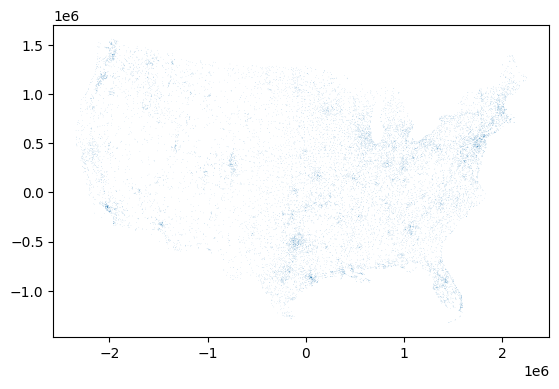

In [10]:
gdf_1mi.plot()

In [11]:
# generate airports buffered by 3 miles
gdf_3mi = gdf.copy()
gdf_3mi["geometry"] = gdf_3mi.buffer(3 * mi_to_meter)

<Axes: >

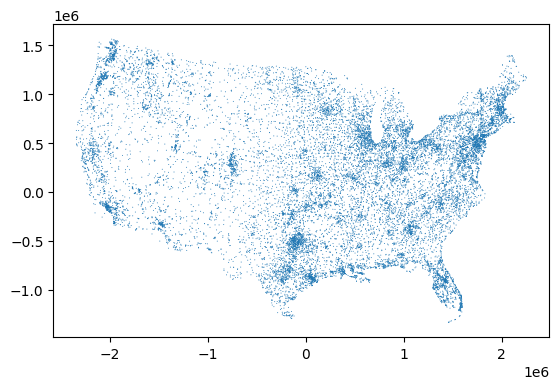

In [12]:
gdf_3mi.plot()

In [13]:
# generate airports buffered by 10 miles
gdf_10mi = gdf.copy()
gdf_10mi["geometry"] = gdf_10mi.buffer(10 * mi_to_meter)

<Axes: >

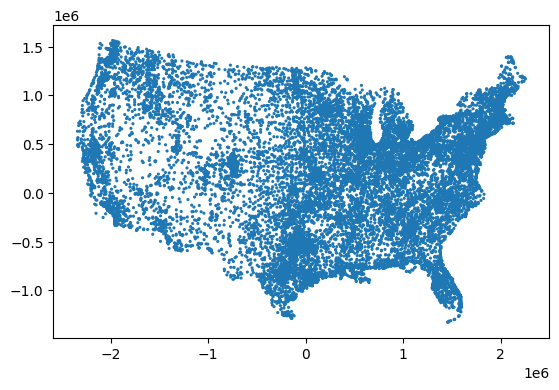

In [14]:
gdf_10mi.plot()

### 4.3 Create Rasters

In [15]:
# generate raster for 1mi airport buffer
vector_to_raster(template_raster, 
                 gdf_1mi, 
                 "value",
                 output_1mi_file)

In [16]:
# generate raster for 3mi airport buffer
vector_to_raster(template_raster, 
                 gdf_3mi, 
                 "value",
                 output_3mi_file)

In [17]:
# generate raster for 10mi airport buffer
vector_to_raster(template_raster, 
                 gdf_10mi, 
                 "value",
                 output_10mi_file)